# Model to detect incoming churn customer based on credit info

In [191]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [95]:
plt.style.use('ggplot')

In [96]:
df = pd.read_csv('data/credit.csv')

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


There is:
- 165k records
- 14 non-null columns
- 3 id cols (id, CustomerId, Surname)
- 10 feature cols (2 is categorical feature)
- 1 target col (Exited)

# Define cols variables

In [98]:
col_target = 'Exited'
cols_id = ['id', 'CustomerId', 'Surname']
cols_feature = list(df.drop([col_target] + cols_id, axis = 1).columns)

In [99]:
cols_feature_cat = list(df[cols_feature].select_dtypes('object').columns)
cols_feature_num = [col for col in cols_feature if col not in cols_feature_cat]
print(f"Numeric features: {cols_feature_num} ")
print(f"Categorical features: {cols_feature_cat}")

Numeric features: ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'] 
Categorical features: ['Geography', 'Gender']


# EDA

## Univariate 

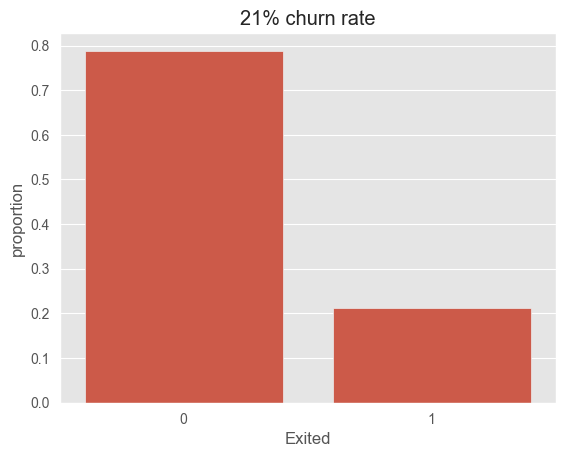

In [100]:
sns.barplot(
    df[col_target].value_counts(normalize=True),
).set(
    title = f"{df[col_target].mean()*100:,.0f}% churn rate"
)
plt.show()

### Categorical features

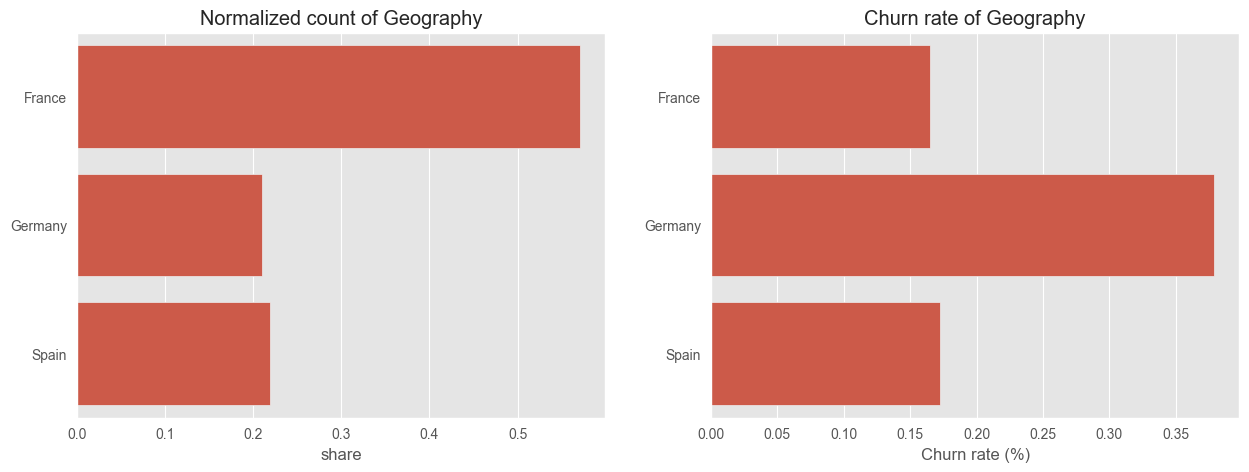

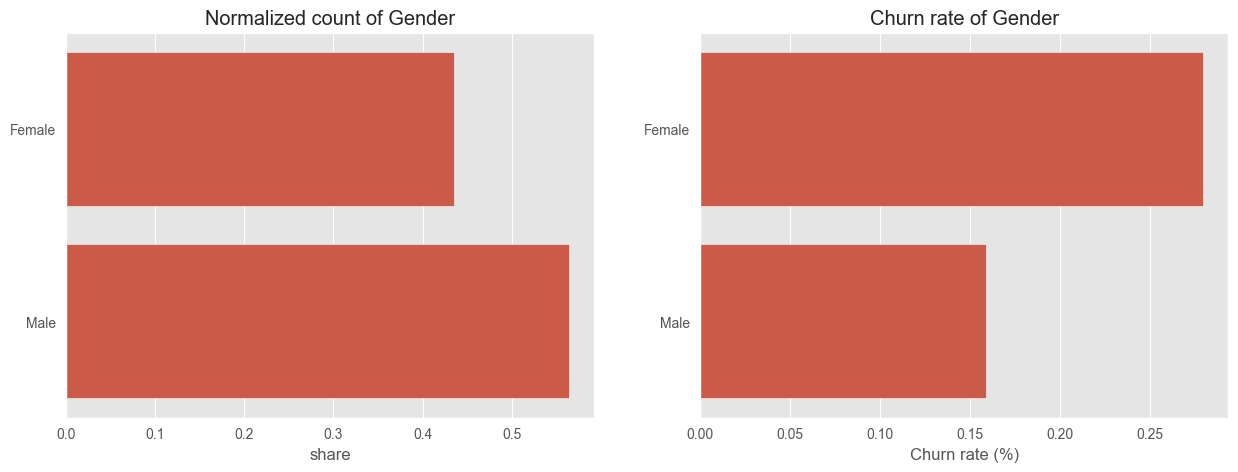

In [101]:
for col in cols_feature_cat:
    fig, (ax_count, ax_target) = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))
    
    sns.barplot(
        df[col].value_counts(normalize = True).sort_index(), 
        orient = 'h',
        ax = ax_count
    ).set(
        title = f'Normalized count of {col}', 
        ylabel = '',
        xlabel = 'share'
    )
    
    sns.barplot(
        df.groupby(col)[col_target].mean().sort_index(), 
        orient = 'h',
        ax = ax_target
    ).set(
        title = f'Churn rate of {col}', 
        ylabel = '',
        xlabel = f"Churn rate (%)",
    )
    plt.show()

### Numeric features

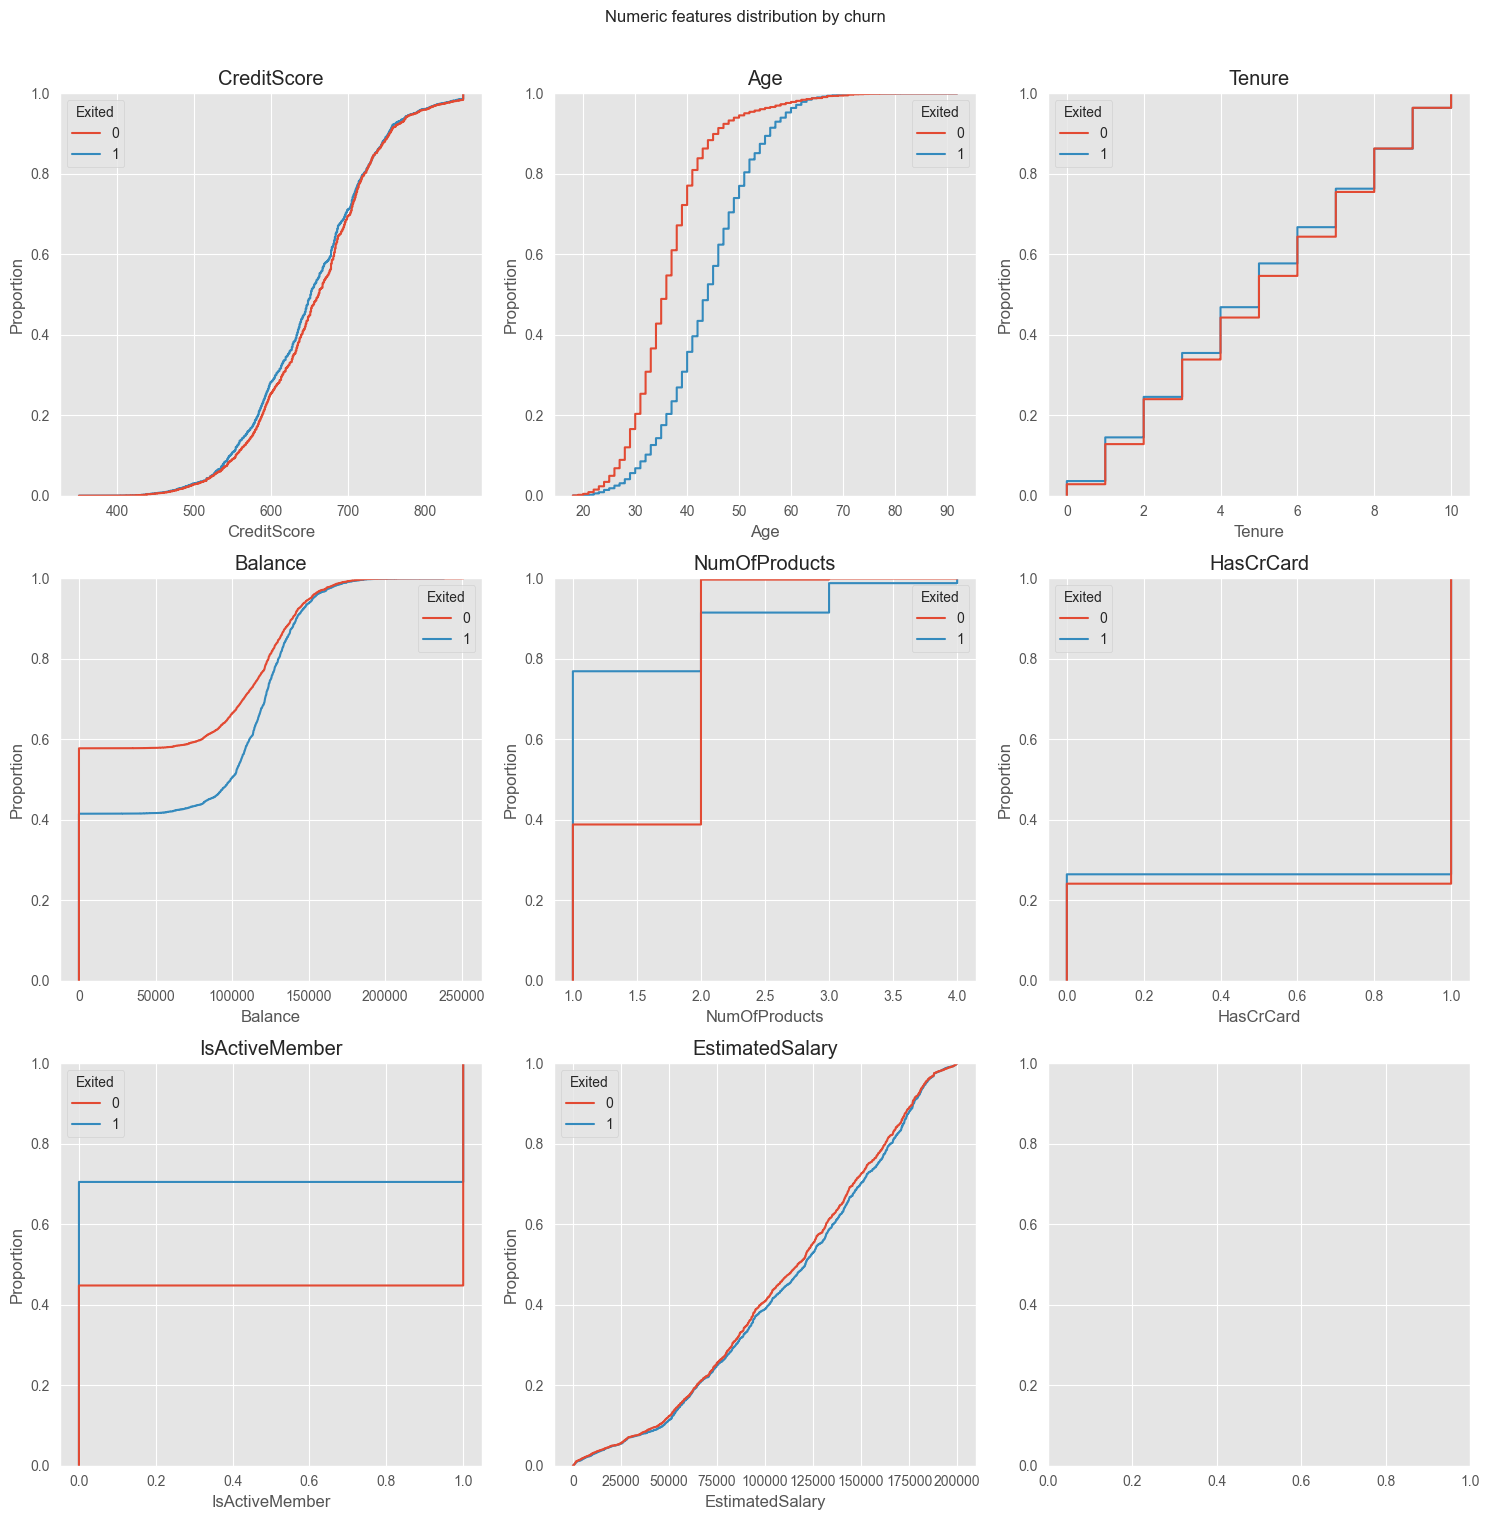

In [105]:
cnt_cols = 3
cnt_rows = len(cols_feature_num)//cnt_cols + 1
fig, axes = plt.subplots(nrows = cnt_rows, ncols = cnt_cols, figsize = (15, 15))
for ax, col in zip(axes.flatten(), cols_feature_num):
    sns.ecdfplot(
        data = df,
        x = col,
        hue = col_target,
        ax = ax
    )
    ax.set_title(col)
fig.suptitle("Numeric features distribution by churn", y=1.01)
fig.tight_layout()
plt.show()

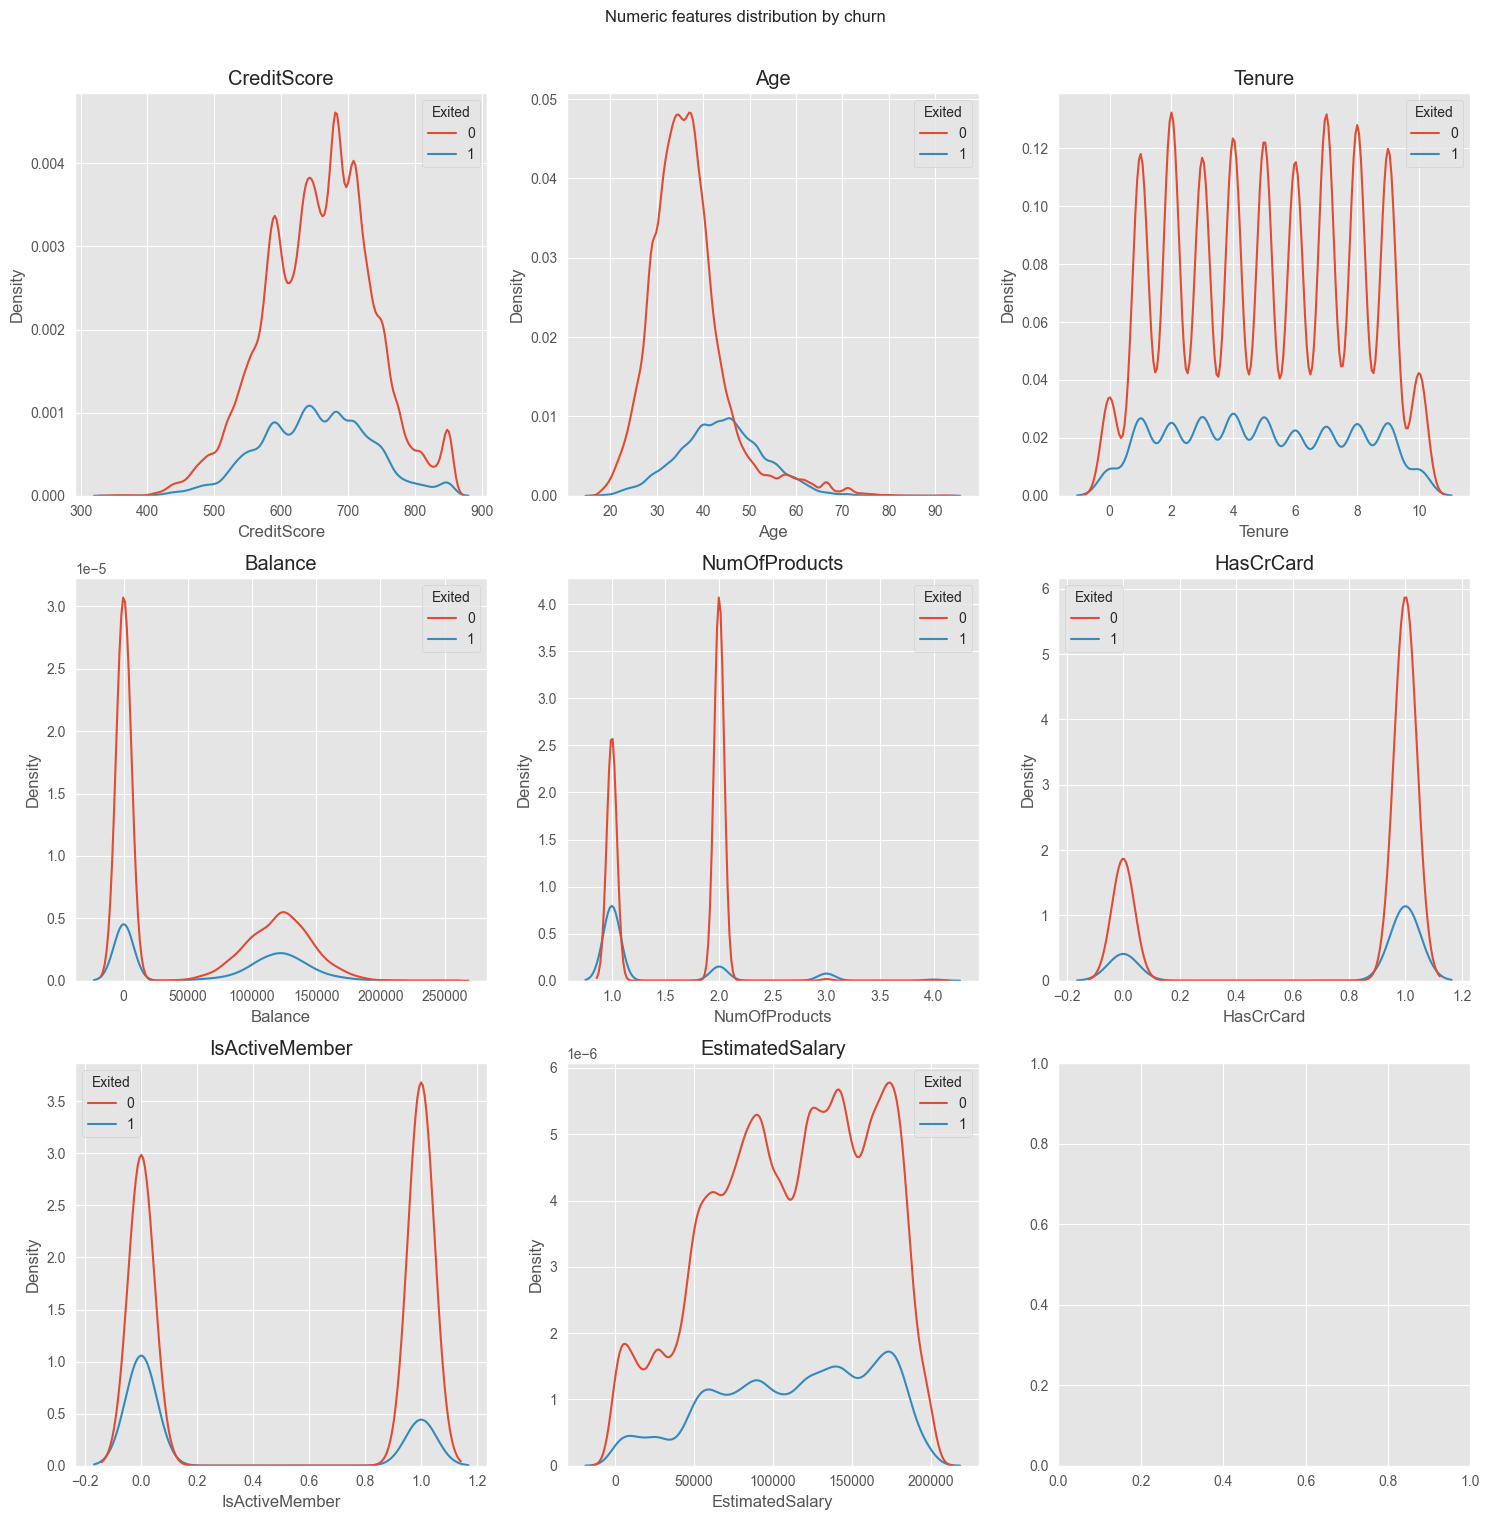

In [129]:
cnt_cols = 3
cnt_rows = len(cols_feature_num)//cnt_cols + 1
fig, axes = plt.subplots(nrows = cnt_rows, ncols = cnt_cols, figsize = (15, 15))
for ax, col in zip(axes.flatten(), cols_feature_num):
    sns.kdeplot(
        data = df,
        x = col,
        hue = col_target,
        ax = ax
    )
    ax.set_title(col)
fig.suptitle("Numeric features distribution by churn", y=1.01)
fig.tight_layout()
plt.show()

## Bivariate

### Cat features vs. Num features

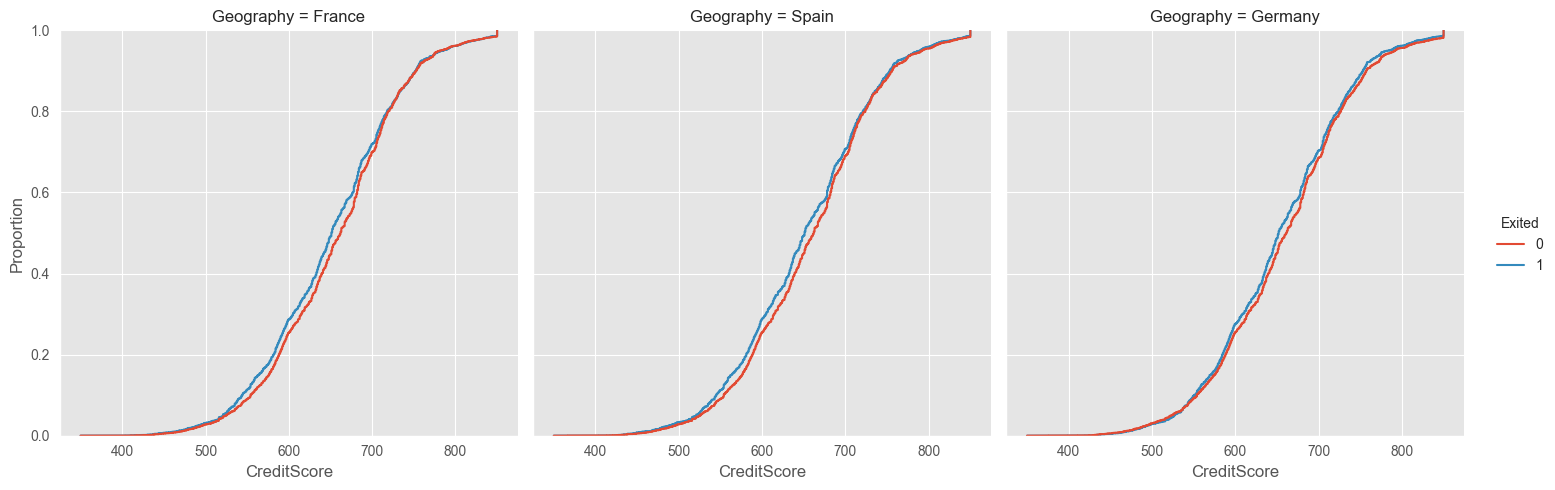

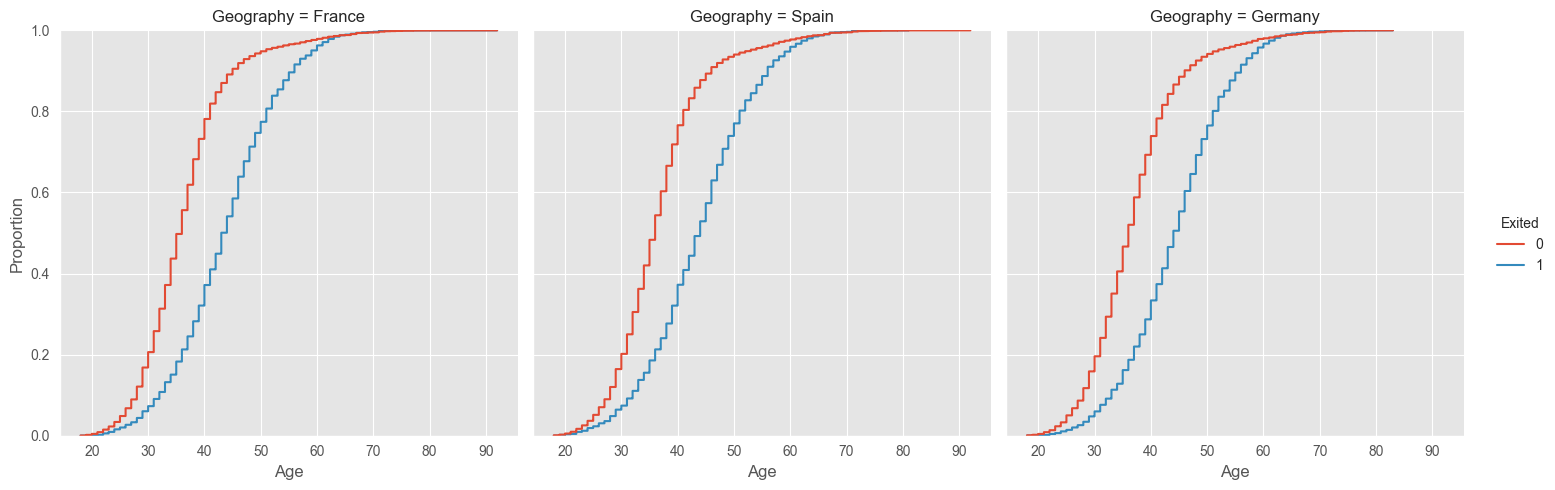

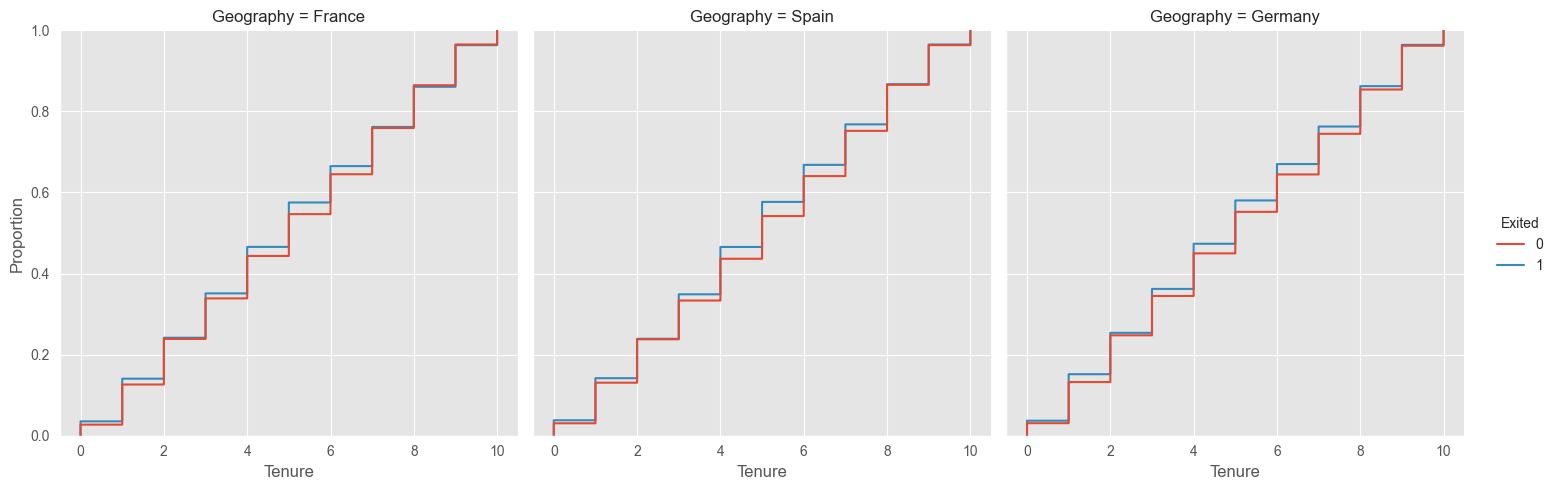

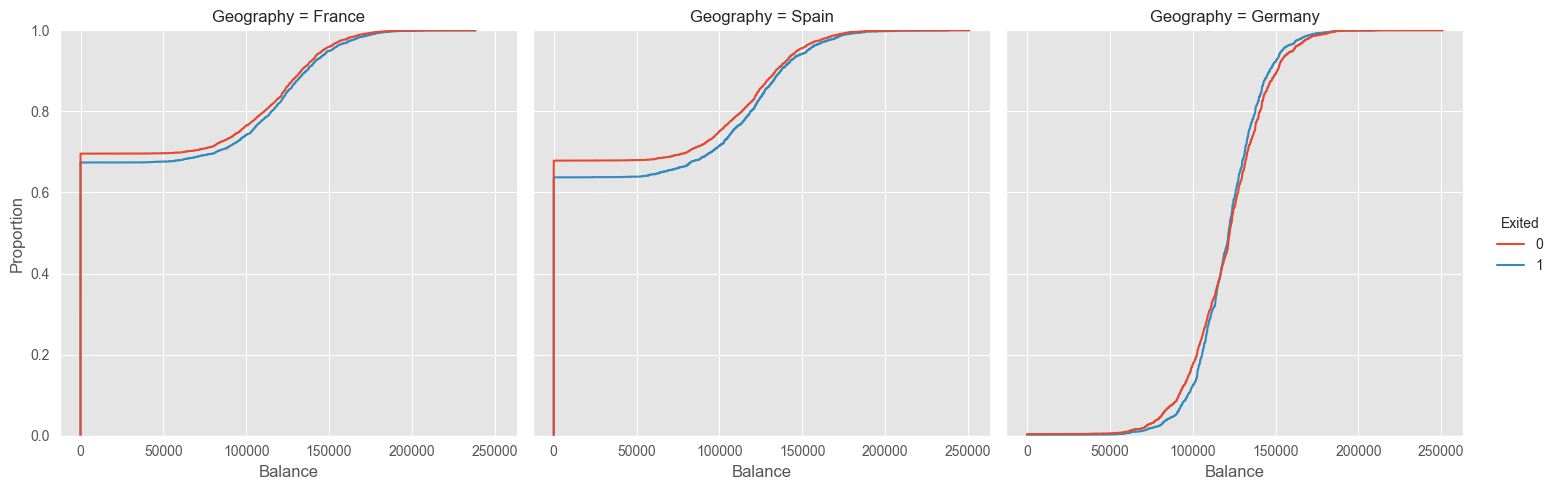

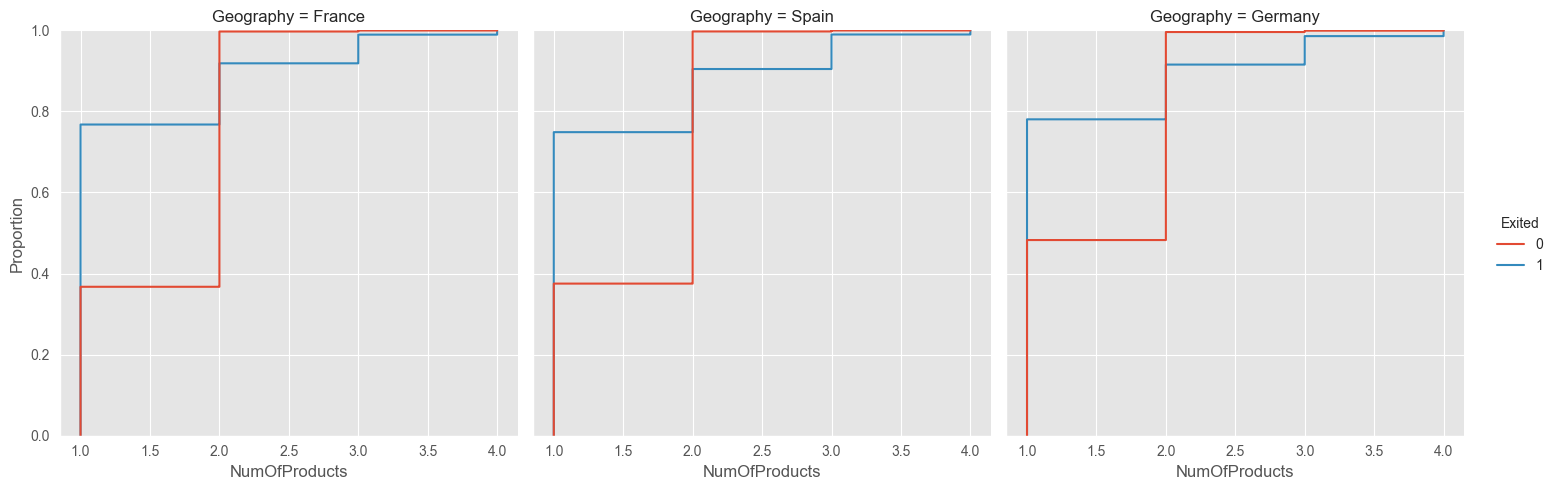

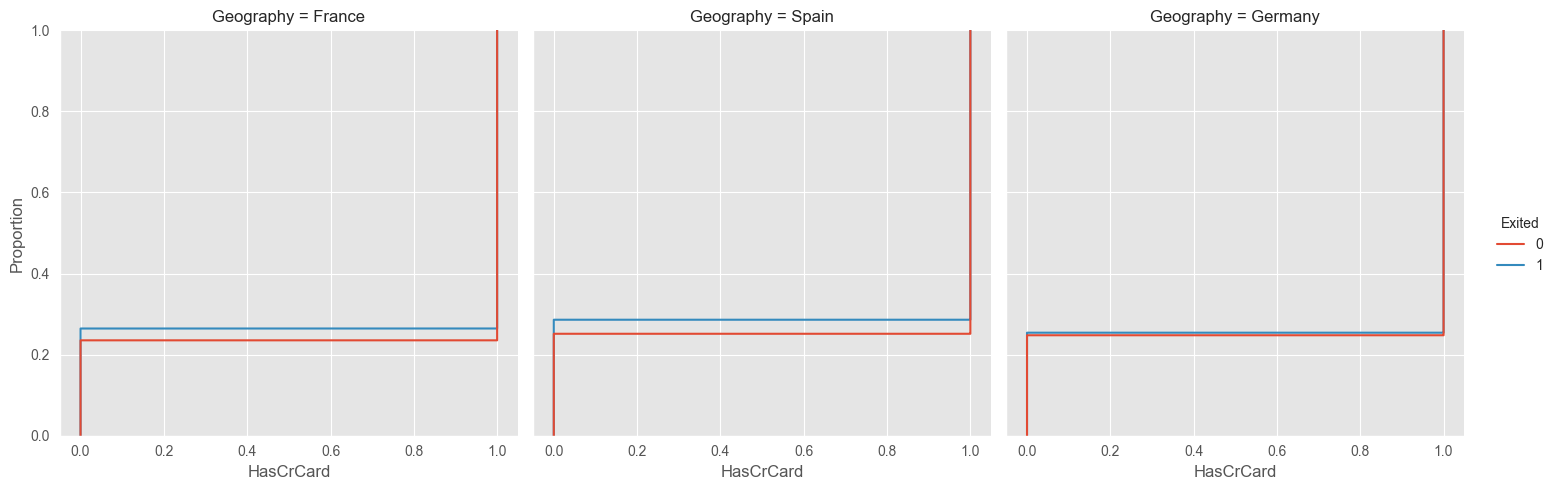

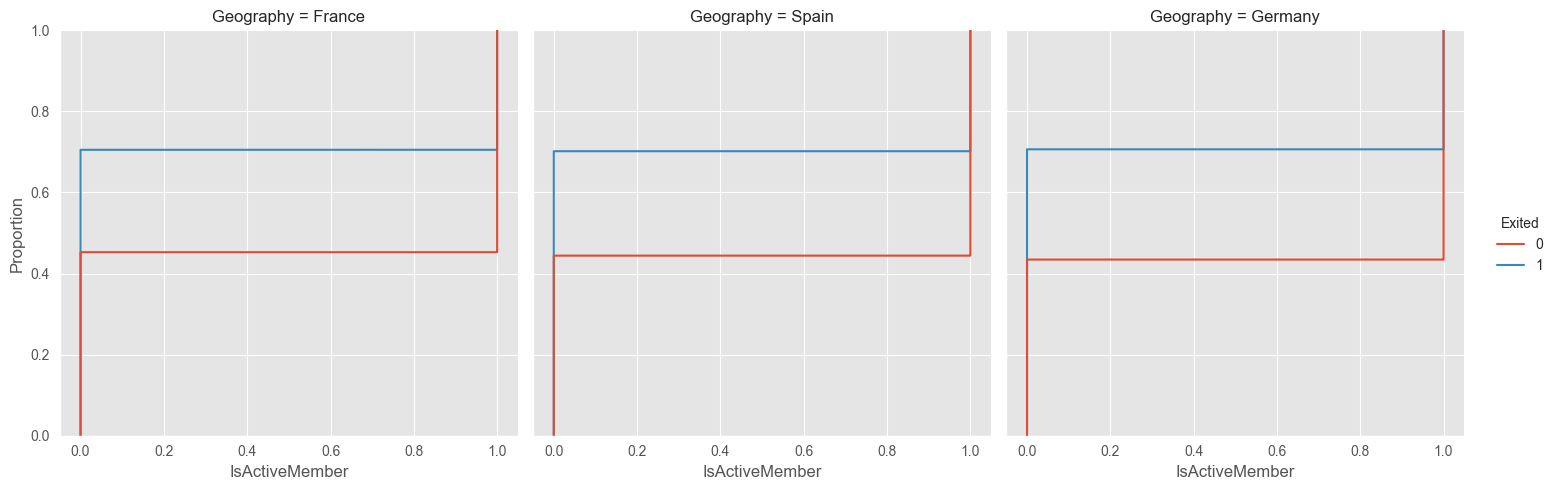

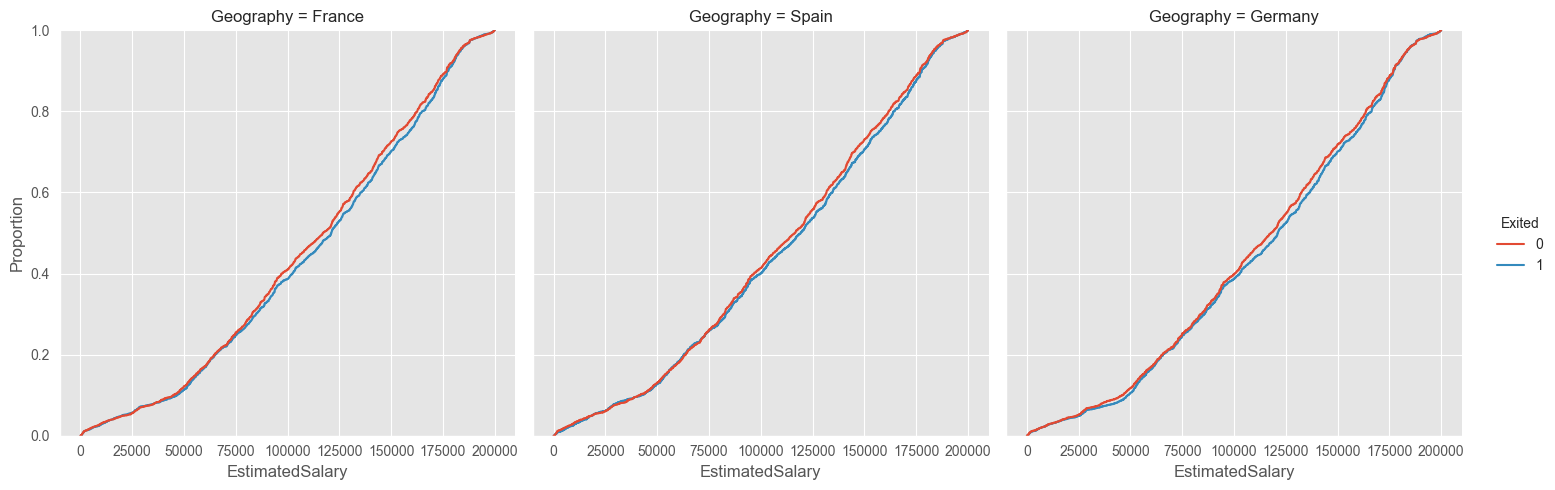

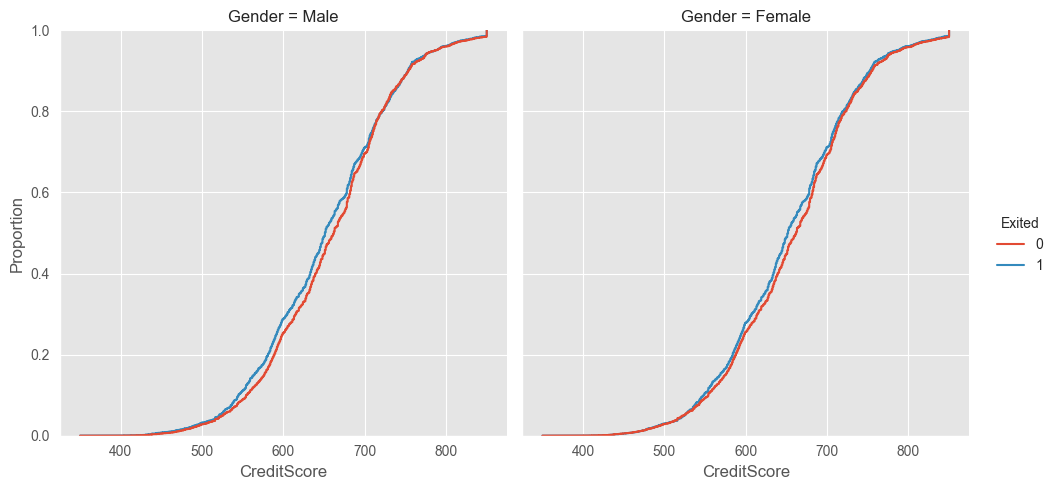

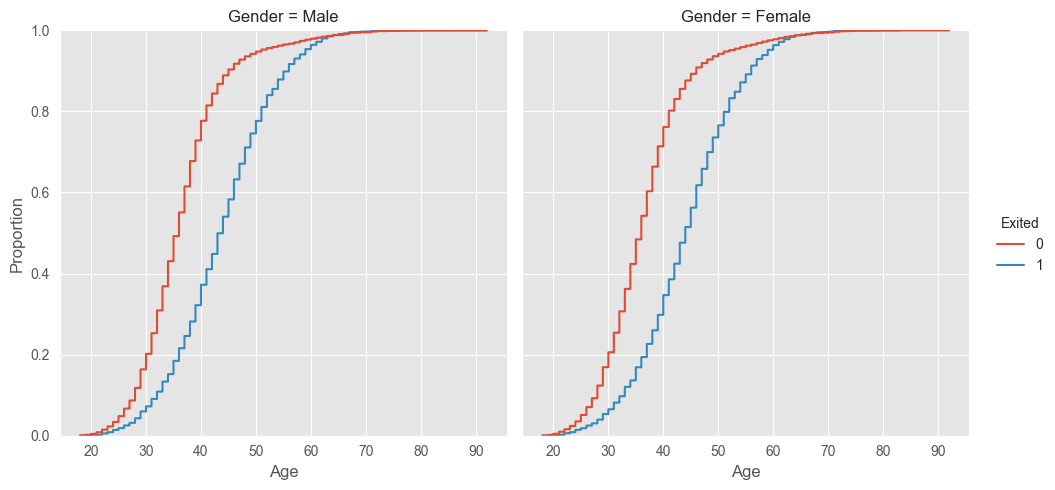

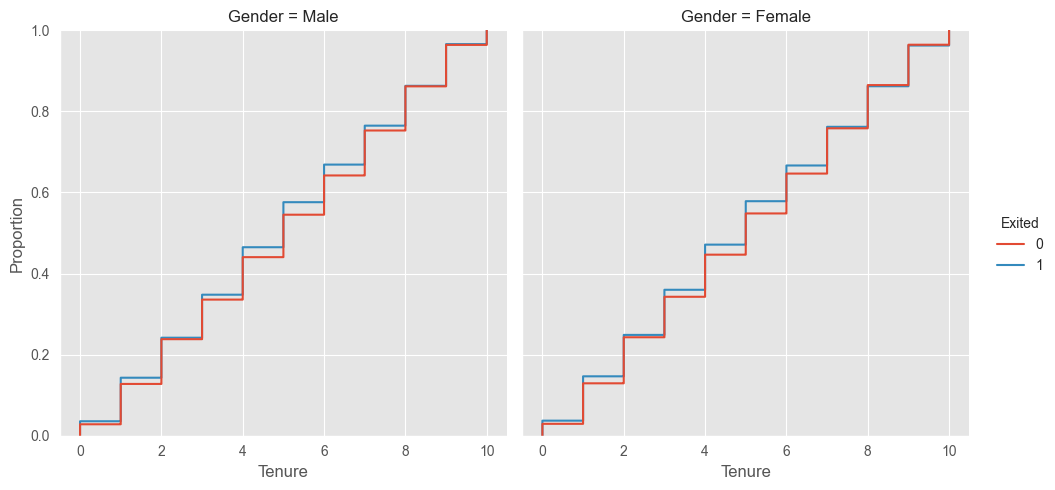

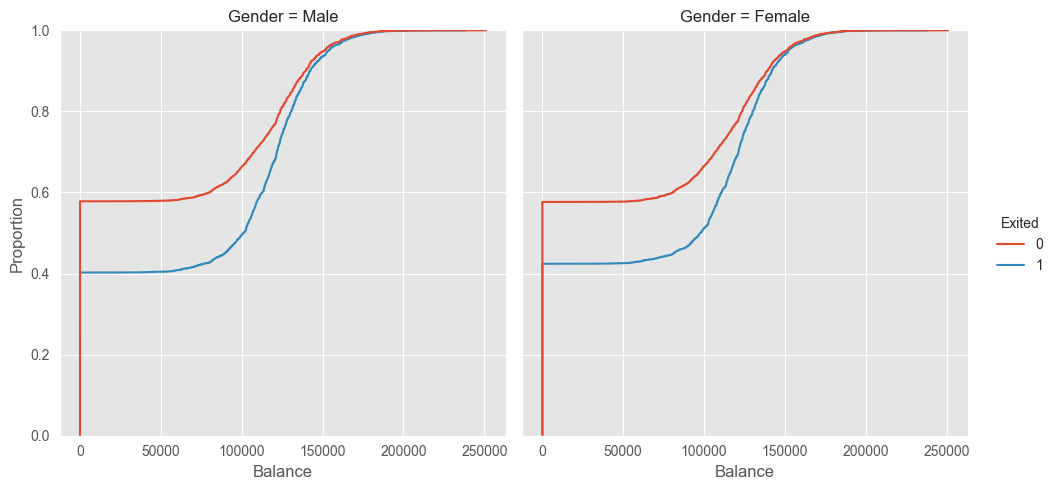

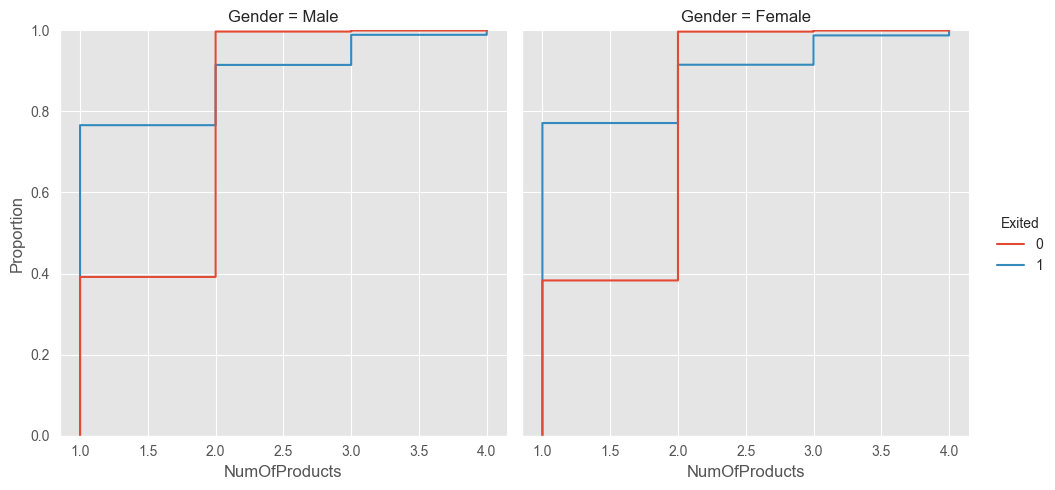

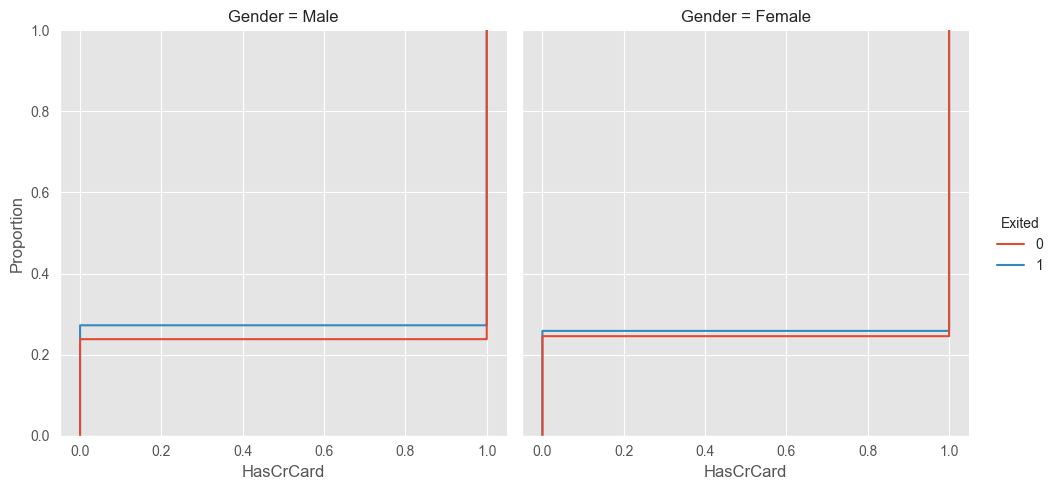

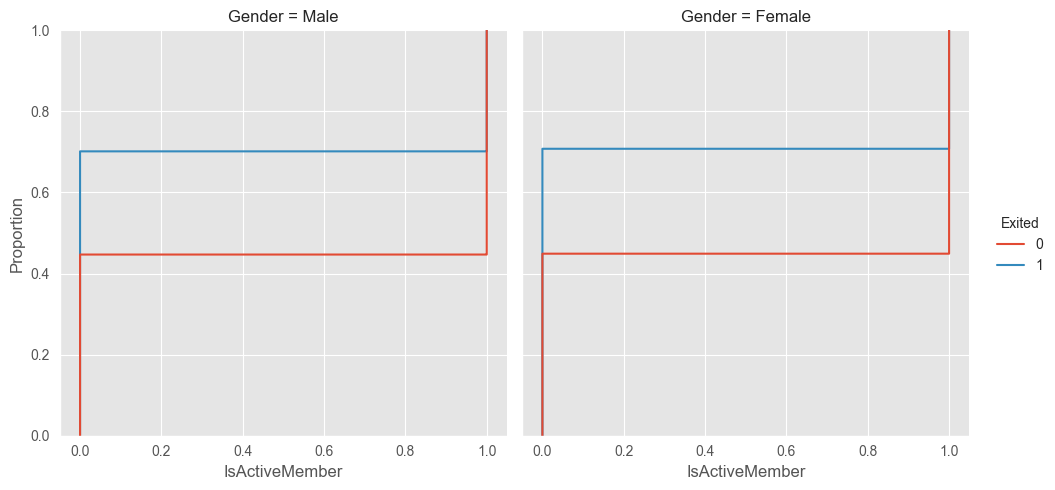

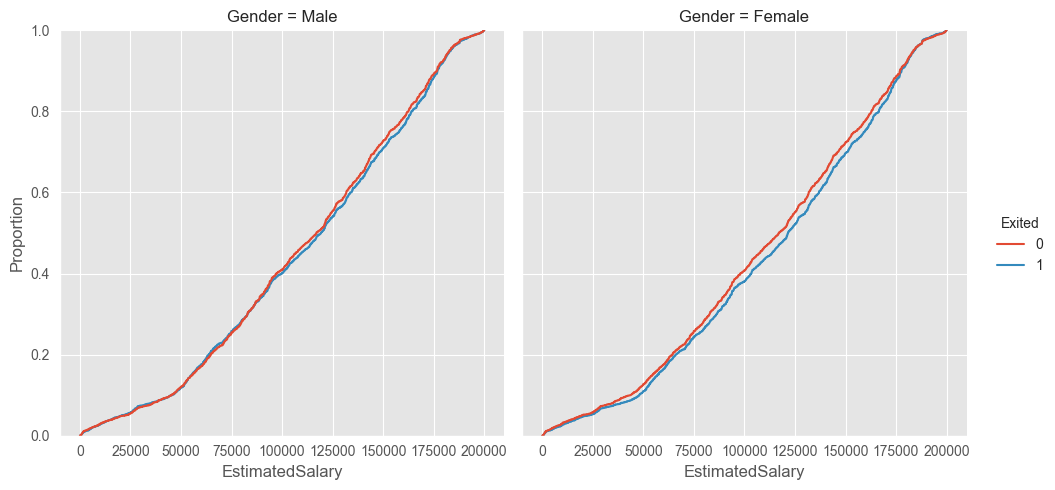

In [104]:
for col_cat in cols_feature_cat:
 
    cnt_cols  = df[col_cat].nunique()
    cnt_rows = len(cols_feature_num)
    for ax, col_num in zip(axes.flatten(), cols_feature_num):
        sns.displot(
            data = df,
            col = col_cat,
            x = col_num,
            hue = col_target,
            kind = 'ecdf',
        )
        plt.show()

In [ ]:
Geography and Balance has interaction effect

### Num features vs. Num features

In [118]:
from sklearn.preprocessing import PowerTransformer
df_tf = pd.DataFrame(
    PowerTransformer(method='yeo-johnson').fit_transform(df[cols_feature_num]),
    columns = cols_feature_num
)
df_tf = pd.concat([df_tf, df[col_target]], axis=1)

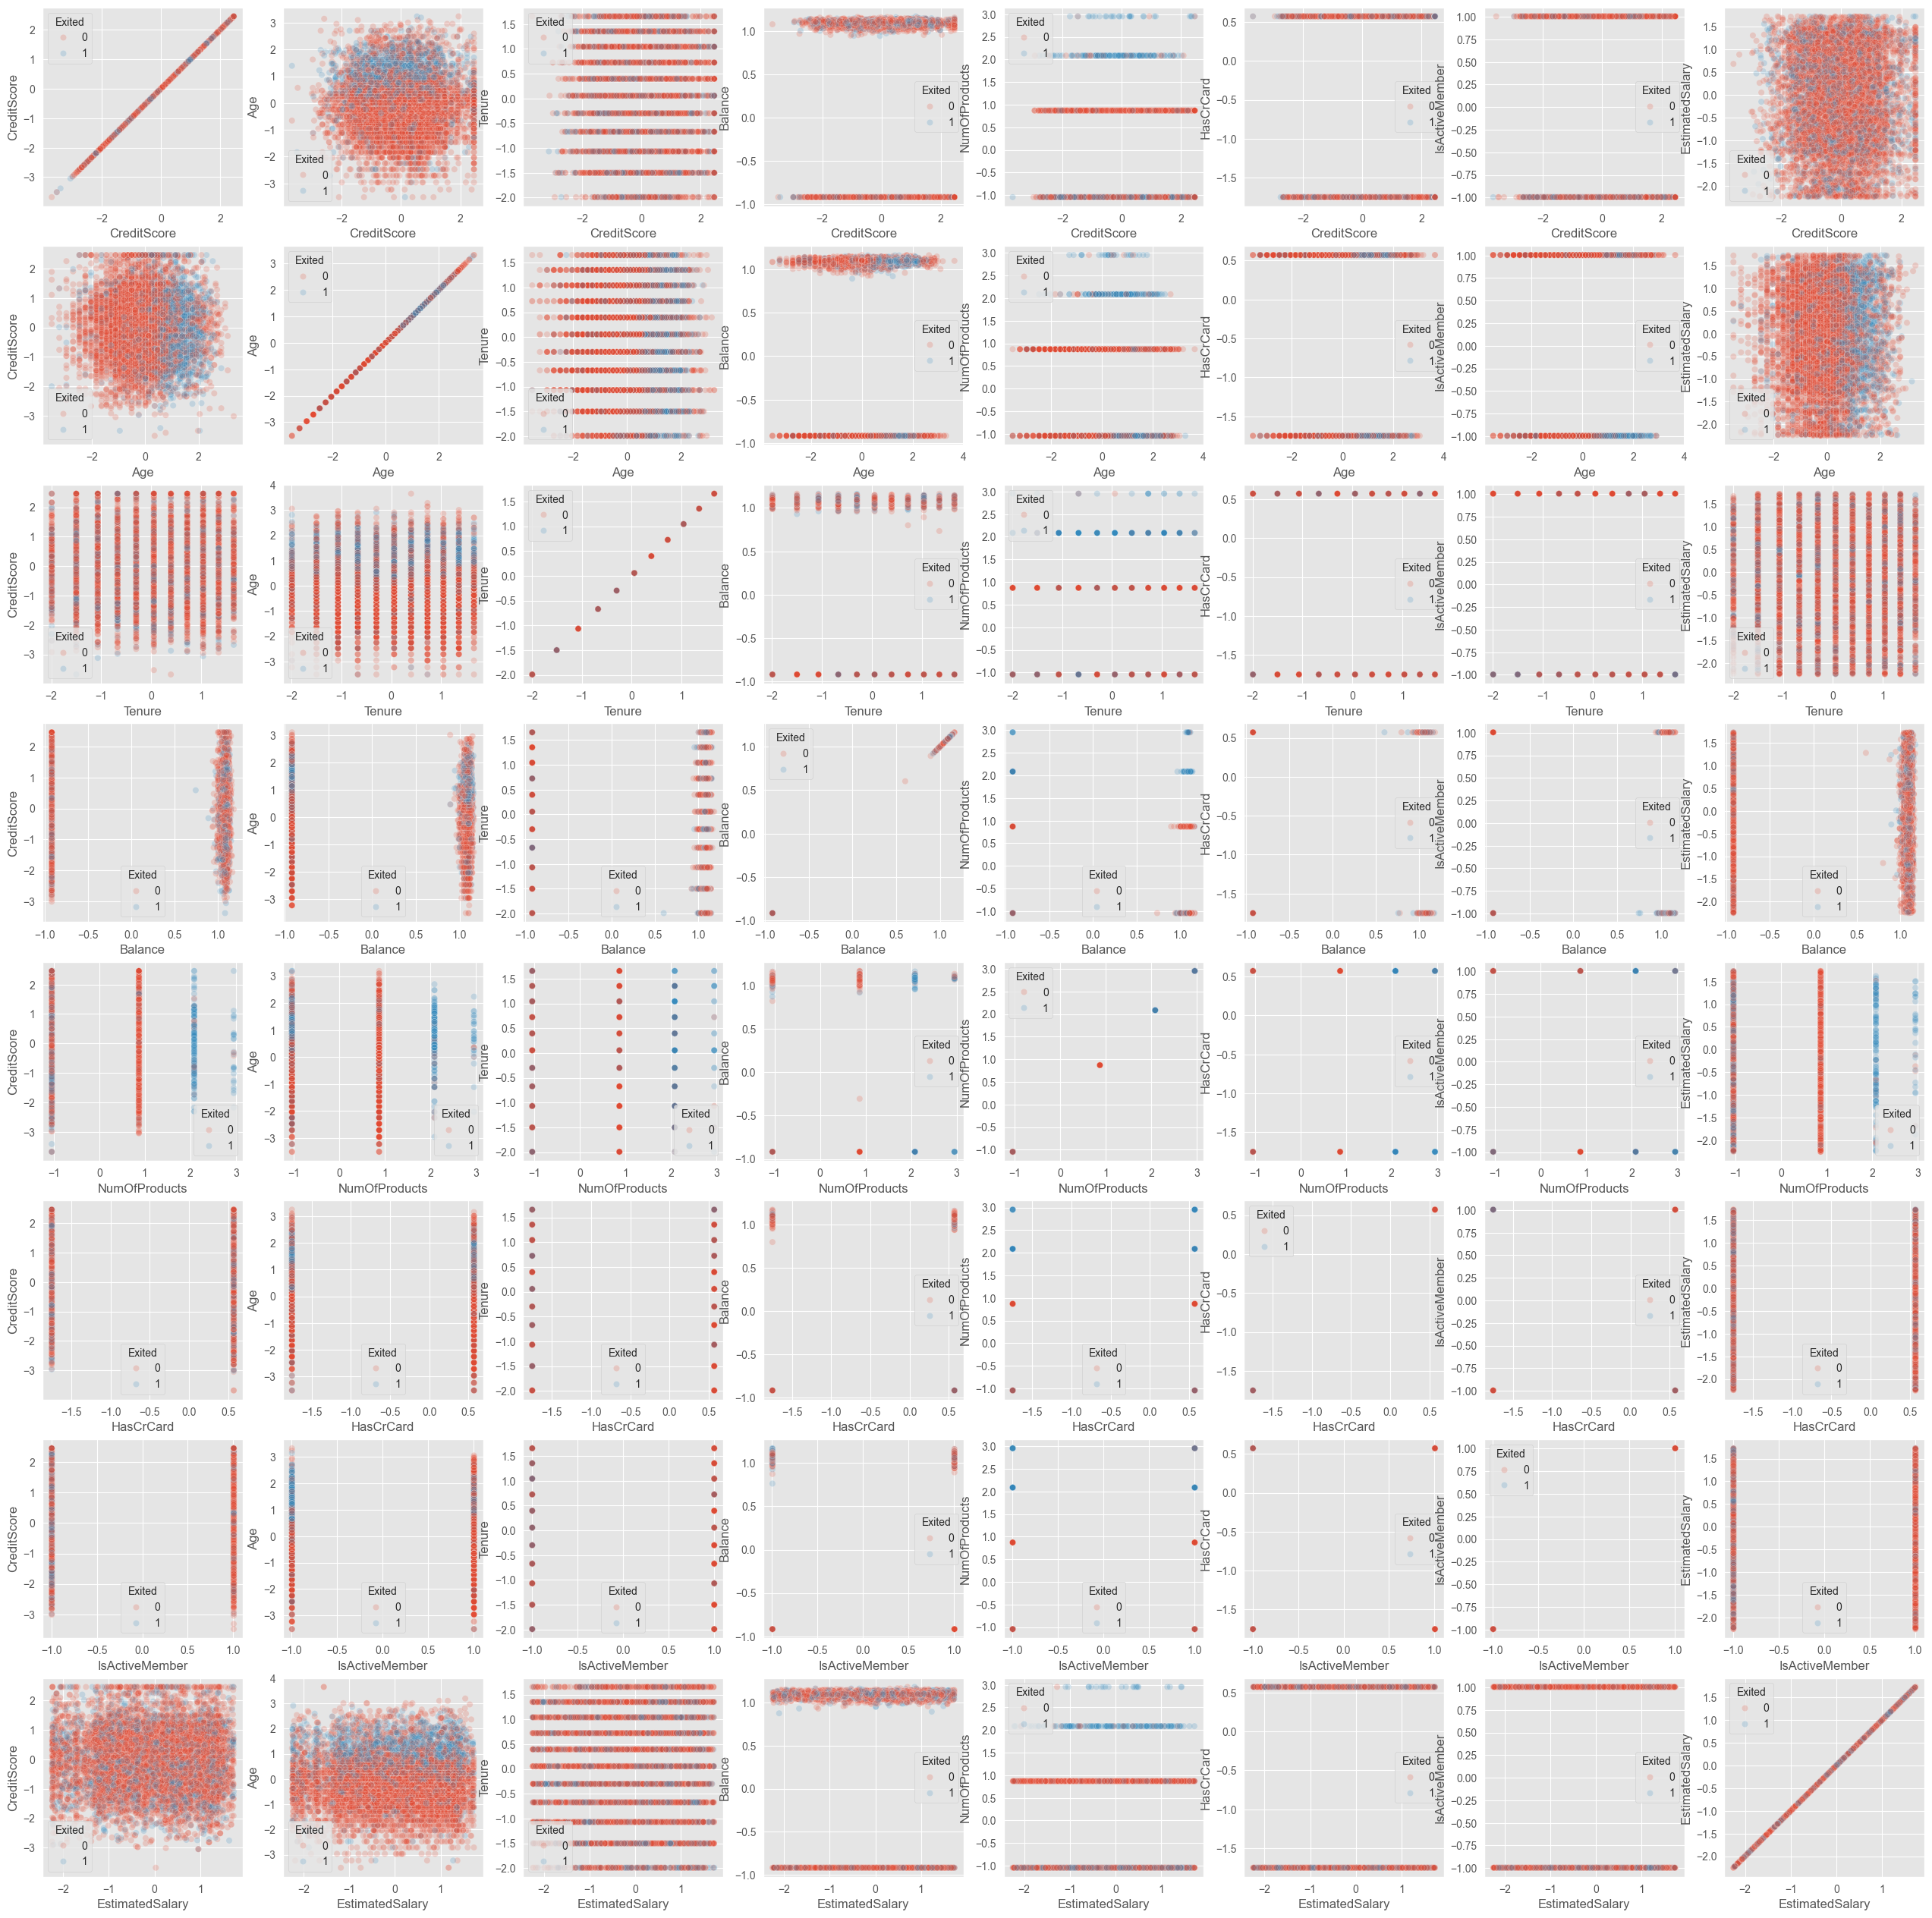

In [144]:
n_rows = len(cols_feature_num)
n_cols = len(cols_feature_num)
fig, axes = plt.subplots(nrows = n_rows, ncols = n_cols, figsize = (4 * n_rows, 4 * n_cols))
for i, col_num_1 in enumerate(cols_feature_num):
    for j, col_num_2 in enumerate(cols_feature_num):
        sns.scatterplot(
            data = df_tf.sample(10000), 
            x = col_num_1,
            y = col_num_2,
            hue = col_target,
            ax = axes[i, j],
            alpha = 0.2,
        )
plt.show()     

## Hypothesis and assumptions
- NumOfProduct, Age, isActiveMember are supposed to be good for classify target 
- Interaction effect: Geography * Balance (Countries have 60% population has 0 Balance, Germany does not follow that pattern)

# Train model

## Setup 

In [309]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import clone, BaseEstimator, TransformerMixin


# Estimators
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

In [213]:
df_train, df_test = train_test_split(df, test_size = 0.2, random_state = 0)
df_train, df_val = train_test_split(df_train, test_size = 0.2, random_state = 0)
train_index, val_index, test_index = (df_train.index, df_val.index, df_test.index)
mask_train = df.index.isin(train_index)
mask_val = df.index.isin(val_index)
mask_test = df.index.isin(test_index)

## Preprocessors

In [305]:
    
preprocessor_cat = ColumnTransformer(
    [
        ("cat", OneHotEncoder(drop=None, sparse_output = False), cols_feature_cat),
    ],
    remainder = 'passthrough',
    verbose_feature_names_out = False
).set_output(transform="pandas")

preprocessor_cat_num_standard = ColumnTransformer(
    [
        ("cat", OneHotEncoder(drop=None, sparse_output = False), cols_feature_cat),
        ("num", StandardScaler(), cols_feature_num),
    ],
    remainder = 'passthrough',
    verbose_feature_names_out = False
).set_output(transform="pandas")


preprocessor_cat_num_power = ColumnTransformer(
    [
        ("cat", OneHotEncoder(drop=None, sparse_output = False), cols_feature_cat),
        ("num", PowerTransformer(method='yeo-johnson'), cols_feature_num),
    ],
    remainder = 'passthrough',
    verbose_feature_names_out = False
).set_output(transform="pandas")

preprocessors = {
    'cat': preprocessor_cat,
    'cat_num_standard': preprocessor_cat_num_standard,
    'cat_num_power': preprocessor_cat_num_power
}

##  Features interaction

In [306]:
class InteractionFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # No fitting process needed for simple feature engineering
        return self
    
    def transform(self, X):
        # Create a new feature as the ratio of two features
        X_transformed = X.copy()
        X_transformed['Germany * Balance'] = X_transformed['Geography_Germany'] * X_transformed['Balance']
        return X_transformed
    
class IdentityTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X 

transformers = {
    'interaction': InteractionFeatures(),
    'identity': IdentityTransformer()
}

## Estimators

In [311]:
estimators = {
    'logistic': LogisticRegression(),
    'tree': DecisionTreeClassifier(),
    'rf': RandomForestClassifier(),
    'lsvm': LinearSVC()
}

## Selecting optimal pipeline

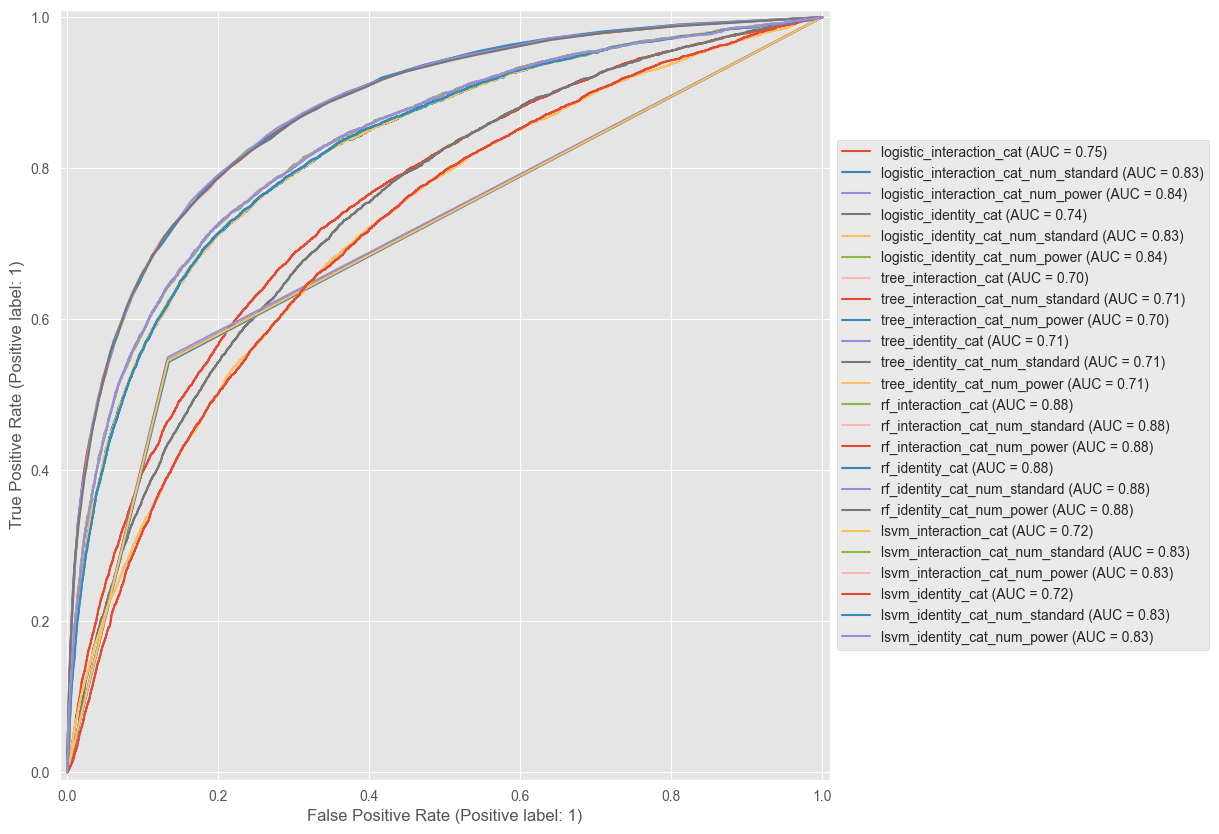

In [312]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 10))

for name_estimator, estimator in estimators.items():
    for name_transformer, transformer in transformers.items():
        for name_preprocessor, preprocessor in preprocessors.items():
            name_pipeline = f"{name_estimator}_{name_transformer}_{name_preprocessor}"
            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('transformer', transformer),
                ('estimator', estimator)
            ])
            pipeline.fit(
                df[mask_train][cols_feature],
                df[mask_train][col_target],
            )
            RocCurveDisplay.from_estimator(
                pipeline, 
                df[mask_val][cols_feature],
                df[mask_val][col_target],
                name=name_pipeline, 
                ax=ax
            )  


# Move legend outside
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.show()

## Optimal pipeline

In [320]:
optimal_preprocessor = preprocessors['cat_num_standard']
optimal_transformer = transformers['identity']
optimal_estimator = estimators['rf']

optimal_pipeline = Pipeline([
    ('preprocessor', optimal_preprocessor),
    ('transformer', optimal_transformer),
    ('estimator', optimal_estimator)
])

optimal_pipeline.fit(
    df[mask_train | mask_val][cols_feature],
    df[mask_train | mask_val][col_target],
)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(sparse_output=False),
                                                  ['Geography', 'Gender']),
                                                 ('num', StandardScaler(),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary'])],
                                   verbose_feature_names_out=False)),
                ('transformer', IdentityTransformer()),
                ('estimator', RandomForestClassifier())])

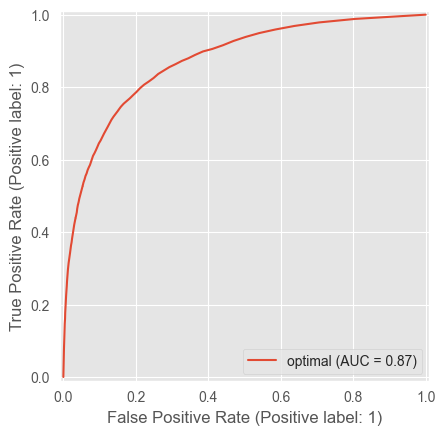

In [321]:
RocCurveDisplay.from_estimator(
    optimal_pipeline, 
    df[mask_test][cols_feature],
    df[mask_test][col_target],
    name='optimal',
)  

# Conclusion
-  Test UAC is approximate with Val UAC -> Model is not overfitting or underfitting -> Ready to use
- There is more room for improvement: hyperparameter tuning of optimal model, feature engineering,...